<h1>1. Get Data</h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
import secret_hitler_helper as shh
from jupyterthemes import jtplot
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

jtplot.style(theme='onedork', context='poster', ticks=False, spines=False, grid=False)

players = pd.read_csv('secrethitler.csv', header=1, index_col='player').fillna(0)

players = pd.concat([players, pd.get_dummies(players.party)], axis=1)

players.head()

,pulled_3_facist,pulled_3_liberal,pulled_2_liberal_1_facist,pulled_2_facist_1_liberal,num_facist_put,num_lib_put,party,player_num,is_hitler,facist,liberal
player,,,,,,,,,,,
1,1.0,0.0,0.0,0.0,1.0,1.0,liberal,6,0,0,1
2,1.0,0.0,1.0,0.0,1.0,1.0,liberal,6,0,0,1
3,1.0,0.0,0.0,0.0,0.0,0.0,liberal,6,0,0,1
4,0.0,0.0,0.0,0.0,1.0,0.0,facist,6,0,1,0
5,0.0,0.0,0.0,1.0,0.0,1.0,liberal,6,0,0,1


<h1>2. Data Analysis</h1>

Create two new columns, total number of facists pulled, and total number of liberals pulled.

In [2]:
players['num_of_facists_pulled'] = shh.get_total_number_of_facist_cards(players)
players['num_of_liberals_pulled'] = shh.get_total_number_of_liberal_cards(players)

Show the correlations, to get a good idea of what columns will help my model.

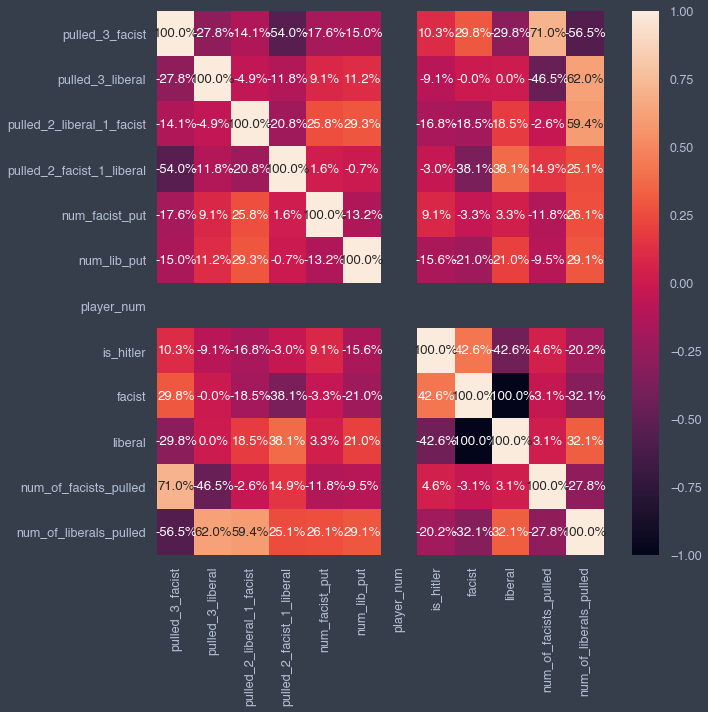

In [3]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(players.corr(), annot=True, fmt='.1%')

Show the highest correlated variables differences between facist and liberals.

Text(0, 0.5, '2 Liberal Cards Drawn')

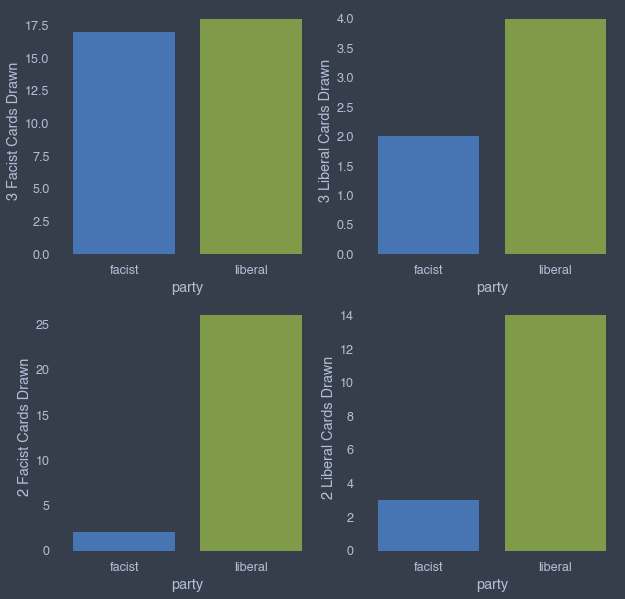

In [4]:
parties = players.groupby('party')
three_facist = parties['pulled_3_facist'].sum()
three_liberal = parties['pulled_3_liberal'].sum()
two_facist = parties['pulled_2_facist_1_liberal'].sum()
two_liberals = parties['pulled_2_liberal_1_facist'].sum()

fig, axes = plt.subplots(2,2,figsize=(10,10))
sns.barplot(three_facist.index, three_facist.values, ax=axes[0,0])
axes[0,0].set_ylabel('3 Facist Cards Drawn')
sns.barplot(three_liberal.index, three_liberal.values, ax=axes[0,1])
axes[0,1].set_ylabel('3 Liberal Cards Drawn')
sns.barplot(two_facist.index, two_facist.values, ax=axes[1,0])
axes[1,0].set_ylabel('2 Facist Cards Drawn')
sns.barplot(two_liberals.index, two_liberals.values, ax=axes[1,1])
axes[1,1].set_ylabel('2 Liberal Cards Drawn')

<h1>3. Modeling</h1>

Remove features that have low impact on predicting outcome.

In [5]:
players_pred_results = players.liberal
players_pred = players.select_dtypes(include='number').drop(['is_hitler', 'facist', 'num_of_facists_pulled',
                                                             'liberal', 'player_num', 
                                                             'num_facist_put', 'pulled_3_liberal'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(players_pred, players_pred_results, random_state=42)

Test a few models, to narrow down to one I like.

In [6]:
pipe = Pipeline([
    ('scalar', StandardScaler())
])

X_train_prepared = pipe.fit_transform(X_train)

log_reg = LogisticRegression(solver="lbfgs")
shh.fit_and_print_model(log_reg, X_train_prepared, y_train)

svc = SVC(gamma="auto", kernel="rbf")
shh.fit_and_print_model(svc, X_train_prepared, y_train)

dec_tree = DecisionTreeClassifier()
shh.fit_and_print_model(dec_tree, X_train_prepared, y_train)

forest = RandomForestClassifier(n_estimators=10)
shh.fit_and_print_model(forest, X_train_prepared, y_train)

<class 'sklearn.linear_model.logistic.LogisticRegression'> ROC AUC score: 0.7337662337662338
<class 'sklearn.linear_model.logistic.LogisticRegression'> F1 score: 0.8115942028985507
<class 'sklearn.svm.classes.SVC'> ROC AUC score: 0.7337662337662338
<class 'sklearn.svm.classes.SVC'> F1 score: 0.8115942028985507
<class 'sklearn.tree.tree.DecisionTreeClassifier'> ROC AUC score: 0.7776998597475456
<class 'sklearn.tree.tree.DecisionTreeClassifier'> F1 score: 0.835820895522388
<class 'sklearn.ensemble.forest.RandomForestClassifier'> ROC AUC score: 0.8044397463002114
<class 'sklearn.ensemble.forest.RandomForestClassifier'> F1 score: 0.8607594936708861


In [7]:
params_log = [
    {'C': [.0001, .001, .01, .1, 1, 10]}
]

params_svc = [
    {'C': [.0001, .001, .01, .1, 1, 10, 100], 'kernel': ['rbf', 'sigmoid', 'linear'], 'gamma': ['auto', 'scale']},
    {'kernel': ['poly'], 'degree': [1,2,3,4,5], 'C': [.0001, .001, .01, .1, 1, 10, 100], 
    'gamma': ['auto', 'scale']}
]

params_dec_tree = [
    {'max_depth': [None, 1, 2, 3, 4, 5, 6], 'min_samples_split': [2,3,4,5,6], 'max_features': [None, 1,2,3,4]}
]

params_forest = [
    {'n_estimators': [1,2,3], 'max_depth': [2, 3, 4], 'min_samples_split': [4,5,6]}
]

shh.grid_and_print_model(log_reg, params_log, X_train_prepared, y_train)
grid = shh.grid_and_print_model(svc, params_svc, X_train_prepared, y_train)
shh.grid_and_print_model(dec_tree, params_dec_tree, X_train_prepared, y_train)
shh.grid_and_print_model(forest, params_forest, X_train_prepared, y_train)
print('')

<class 'sklearn.linear_model.logistic.LogisticRegression'> best score is 0.7037037037037037
<class 'sklearn.svm.classes.SVC'> best score is 0.7592592592592593
<class 'sklearn.tree.tree.DecisionTreeClassifier'> best score is 0.7777777777777778
<class 'sklearn.ensemble.forest.RandomForestClassifier'> best score is 0.7592592592592593



{'C': 0.1, 'gamma': 'auto', 'kernel': 'linear'}


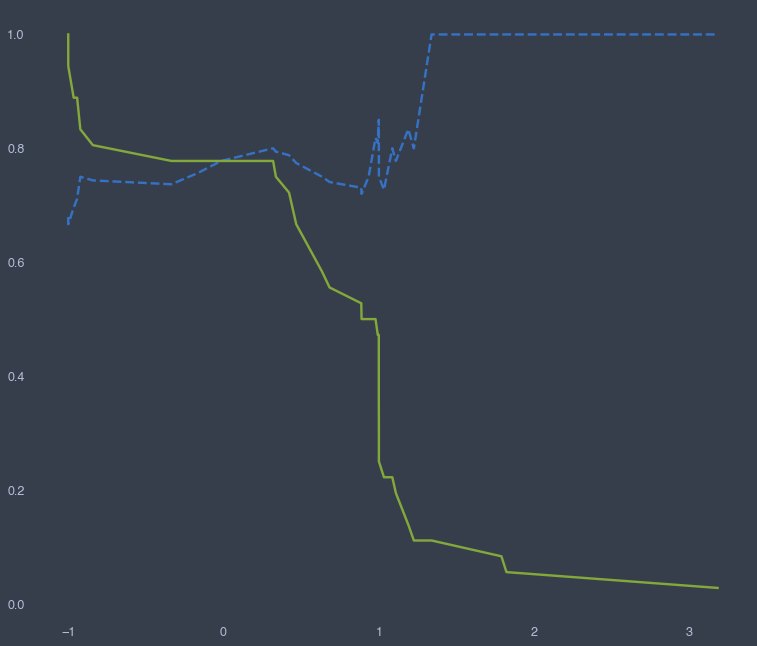

In [8]:
print(grid.best_params_)
y_probas = cross_val_predict(grid, X_train_prepared, y_train, method="decision_function", cv=3)

pre, recalls, thresholds = precision_recall_curve(y_train, y_probas)

plt.plot(thresholds, pre[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

0.8115942028985507
[[13  5]
 [ 8 28]]
ROC UC score: 0.7337662337662338


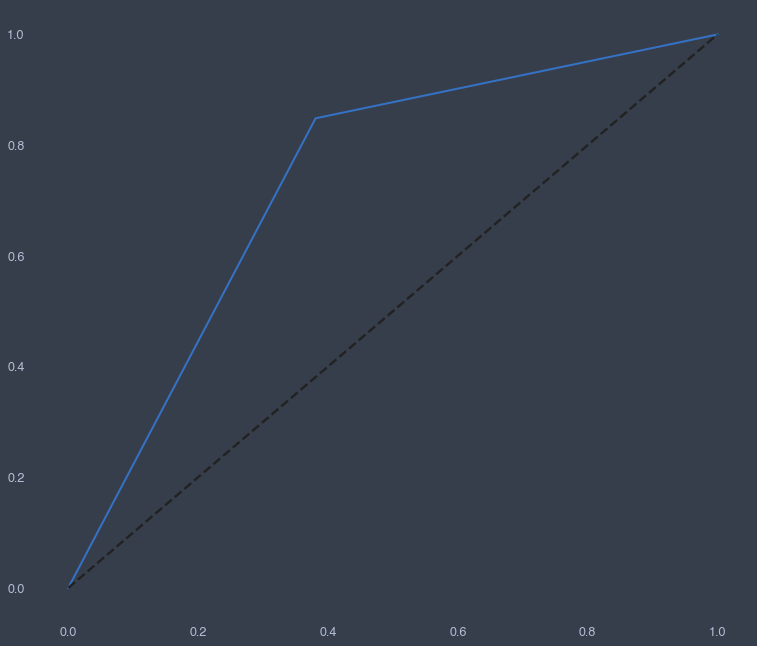

In [9]:
predictions = grid.decision_function(X_train_prepared) > 0

print(f1_score(y_train, predictions))
print(confusion_matrix(y_train == 1, predictions))
fpr, tpr, thresholds = roc_curve(predictions, y_train)

print('ROC UC score: {}'.format(roc_auc_score(predictions, y_train)))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], 'k--')